# ナイーブベイス

## ライブラリーのインポート

In [44]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

## データセットのインポート

In [45]:
# データセットをロード
dataset = datasets.load_iris()

# 一意なクラスラベルを出力
print('columns:', dataset.feature_names)
print('ラベルの種類:', np.unique(dataset.target))

columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
ラベルの種類: [0 1 2]


## カーネルSVM

In [46]:
pd.set_option('display.max_columns', None)
# データセットの特徴量をDataFrameに変換
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

# 目標変数（ターゲット）をDataFrameに追加
df['target'] = dataset.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [47]:
print(f'データの形式：{df.shape}')
print(f'欠損値の数：{df.isnull().sum().sum()}')

データの形式：(150, 5)
欠損値の数：0


## 相関関係の確認

In [48]:
corr_matrix = df.corr() # 相関行列を計算

# "target"との相関が高い順に列を並び替える
sorted_columns = corr_matrix.abs().sort_values('target', ascending=False).index

# 並び替えた列順でDataFrameの相関行列を表示
sorted_corr_matrix = corr_matrix[sorted_columns].loc[sorted_columns]
sorted_corr_matrix

,target,petal width (cm),petal length (cm),sepal length (cm),sepal width (cm)
target,1.000000,0.956547,0.949035,0.782561,-0.426658
petal width (cm),0.956547,1.000000,0.962865,0.817941,-0.366126
petal length (cm),0.949035,0.962865,1.000000,0.871754,-0.428440
sepal length (cm),0.782561,0.817941,0.871754,1.000000,-0.117570
sepal width (cm),-0.426658,-0.366126,-0.428440,-0.117570,1.000000


## 説明変数と目的変数に分割

In [49]:
# 相関関係の高い2つの特徴量を抽出
select_features = ['petal width (cm)', 'petal length (cm)']
X = df.loc[:, select_features].values
y = df.loc[:, 'target'].values

## 訓練データとテストデータに分割

In [50]:
# 全体の30%をテストデータととする
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

In [51]:
# 各データセットのラベルの比率
print('入力データセットのyラベルの比率:', np.bincount(y))
print('訓練サブセットのyラベルの比率:', np.bincount(y_train))
print('テストサブセットのyラベルの比率:', np.bincount(y_test))

入力データセットのyラベルの比率: [50 50 50]
訓練サブセットのyラベルの比率: [35 35 35]
テストサブセットのyラベルの比率: [15 15 15]


## 特徴量のスケーリング

In [52]:
sc = StandardScaler()
# 訓練データの平均と標準偏差を計算
sc.fit(X_train)
# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 訓練データによるモデルの学習

In [53]:
# ガウスナイーブベイズのインスタンスを生成
classifier = GaussianNB()
# 訓練データをモデルに適合させる
classifier.fit(X_train_std, y_train)

GaussianNB()

## 新しいデータポイントでの予測

In [54]:
# 新しいデータポイントで予測
new_data = [[1.5,4.0]]
pred_label = classifier.predict(sc.transform(new_data))[0]
print(f'予測したクラス:{pred_label}({dataset.target_names[pred_label]})')

予測したクラス:1(versicolor)


## テストデータで予測

In [55]:
# テストデータで予測を実施
y_pred = classifier.predict(X_test_std)

## モデルの性能評価

In [56]:
# 正分類のデータ点の個数を表示
print(f'正分類のデータ点: {(y_test == y_pred).sum()}個/{len(y_test)}個' )

# 分類の正解率を表示
print(f'Accuracy(Test): {accuracy_score(y_test, y_pred):.3f}')


正分類のデータ点: 45個/45個
Accuracy(Test): 1.000


## 性能評価の可視化

In [57]:
# 訓練データとテストデータの最小値と最大値を計算
def calculate_bounds(X1, X2):
    X1_min, X1_max = X1.min() - (X1.max()-X1.min())/20, X1.max() + (X1.max()-X1.min())/20
    X2_min, X2_max = X2.min() - (X2.max()-X2.min())/20, X2.max() + (X2.max()-X2.min())/20
    return X1_min, X1_max, X2_min, X2_max

In [58]:
def plot_data(ax, X_set, y_set, X1, X2, Z, colors, kind, classifier):
    cmap = ListedColormap(colors[:len(np.unique(y_set))])
    ax.contourf(X1, X2, Z, alpha=0.3, cmap=cmap)
    for idx, feature in enumerate(np.unique(y_set)):
        ax.scatter(x=X_set[y_set == feature, 0], 
                   y=X_set[y_set == feature, 1],
                   alpha=0.5, 
                   color=colors[idx],
                   marker='o', 
                   label=feature, 
                   edgecolor='black')
    ax.set_xlabel(select_features[0])
    ax.set_ylabel(select_features[1])
    ax.set_title(f'{type(classifier).__name__} ({kind})')
    ax.legend(loc='best')

In [59]:
def plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier):
    # マーカーとカラーマップの準備
    colors = ('red', 'blue', 'green')
    
    # スケーリング前の元のデータに変換
    X_train_set, y_train_set = sc.inverse_transform(X_train_std), y_train
    X_test_set, y_test_set = sc.inverse_transform(X_test_std), y_test
    
    # 訓練データとテストデータの範囲を統一
    X_combined = np.vstack((X_train_set, X_test_set))
    X1_min, X1_max, X2_min, X2_max = calculate_bounds(X_combined[:, 0], X_combined[:, 1])
    
    # グリッドポイントの生成
    X1, X2 = np.meshgrid(np.arange(X1_min, X1_max, step=(X1_max - X1_min) / 1000),
                         np.arange(X2_min, X2_max, step=(X2_max - X2_min) / 1000))
    # 各特徴を1次元配列に変換して予測を実行
    Z = classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T))
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(X1.shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # 訓練データとテストデータのプロット
    plot_data(ax[0], X_train_set, y_train_set, X1, X2, Z, colors, "Training set", classifier)
    plot_data(ax[1], X_test_set, y_test_set, X1, X2, Z, colors, "Test set", classifier)
    
    plt.tight_layout()
    plt.show()

[[2.5 5.7]
 [2.2 6.7]
 [2.3 5.3]
 [0.2 1. ]
 [0.2 1.4]
 [0.2 1.3]
 [1.  3.3]
 [1.9 5.3]
 [1.4 4.6]
 [2.1 5.5]
 [0.3 1.4]
 [1.6 4.7]
 [1.1 3. ]
 [1.3 4.6]
 [0.2 1.4]
 [0.2 1.5]
 [2.3 6.1]
 [1.1 3.9]
 [1.1 3.8]
 [1.5 5. ]
 [2.  6.4]
 [1.3 4.2]
 [0.2 1.4]
 [0.4 1.5]
 [1.  3.3]
 [1.2 3.9]
 [0.4 1.7]
 [1.4 4.7]
 [1.8 5.5]
 [2.3 5.9]
 [2.4 5.6]
 [1.6 5.1]
 [1.8 4.8]
 [2.2 5.6]
 [0.2 1.4]
 [0.2 1.5]
 [0.1 1.1]
 [1.2 4.7]
 [0.2 1.4]
 [0.4 1.5]
 [1.9 6.1]
 [1.  4. ]
 [1.8 4.8]
 [0.4 1.3]
 [0.2 1.5]
 [0.1 1.5]
 [1.5 4.9]
 [1.4 4.4]
 [0.4 1.6]
 [1.2 4.2]
 [1.  3.5]
 [1.  3.5]
 [1.8 5.8]
 [0.3 1.3]
 [1.4 4.8]
 [1.7 5. ]
 [1.3 4.4]
 [1.3 4. ]
 [2.3 5.4]
 [0.2 1.6]
 [1.3 4.3]
 [1.9 5. ]
 [1.5 4.5]
 [1.5 4.5]
 [2.1 5.6]
 [1.3 4.2]
 [2.3 6.9]
 [0.2 1.5]
 [1.4 3.9]
 [1.8 6. ]
 [1.7 4.5]
 [2.1 5.7]
 [2.3 5.2]
 [0.3 1.4]
 [1.8 6.3]
 [0.3 1.3]
 [0.2 1.4]
 [2.2 5.8]
 [1.3 4.3]
 [0.2 1.7]
 [0.2 1.6]
 [0.2 1.6]
 [0.2 1.3]
 [0.2 1.2]
 [1.2 4. ]
 [2.1 6.6]
 [2.  6.7]
 [1.8 5.5]
 [0.2 1.2]
 [1.9 5.1]
 [0.2 1.3]

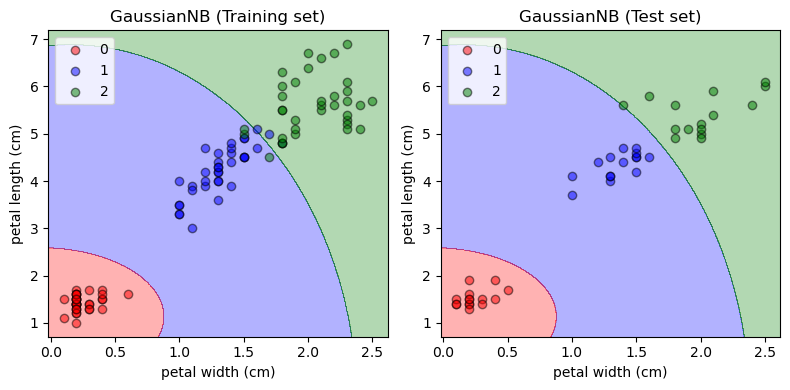

In [60]:
# 決定境界のプロット
if len(select_features) == 2:
    plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier)
else:
    print("特徴量が2個の場合のみプロットが可能です。選択された特徴量の数:", len(select_features))


## gammmaによるパラメーターの影響

### gammma=0.5

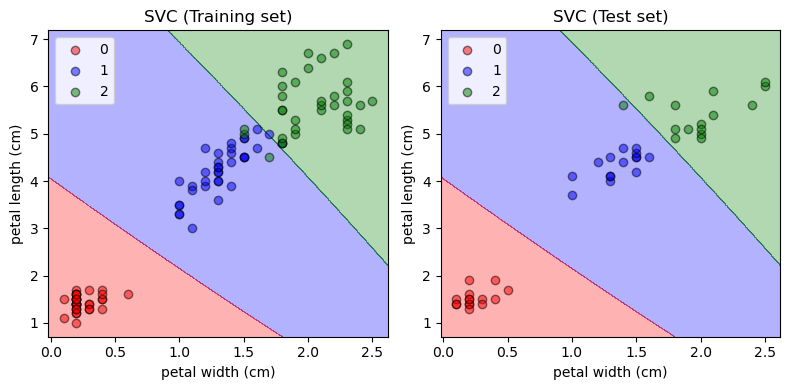

In [88]:
# 線形SVMのインスタンスを生成
classifier = SVC(kernel='rbf', C=1, gamma=0.1,random_state=0)
# 訓練データをモデルに適合させる
classifier.fit(X_train_std, y_train)
# テストデータで予測を実施
y_pred = classifier.predict(X_test_std)
# 決定境界のプロット
plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier)

### gamma=100

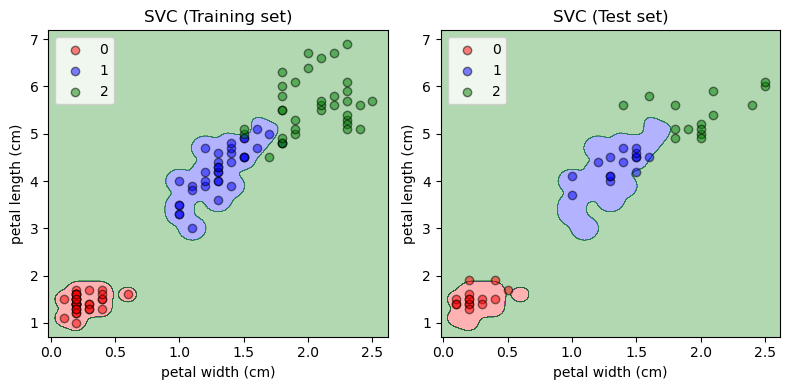

In [87]:
# 線形SVMのインスタンスを生成
classifier = SVC(kernel='rbf', C=1, gamma=100,random_state=0)
# 訓練データをモデルに適合させる
classifier.fit(X_train_std, y_train)
# テストデータで予測を実施
y_pred = classifier.predict(X_test_std)
# 決定境界のプロット
plot_decision_regions(X_train_std, X_test_std, y_train, y_test, classifier)